In [2]:
import tensorflow as tf
print(tf.__version__)

2.10.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [3]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [4]:
# Save the input and target variables
print(diabetes_dataset.keys())

data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [5]:
targets = (targets -targets.mean(axis=0)) / targets.std()

In [6]:
# Normalise the target data (this will make clearer training curves)

targets

array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [7]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split 
train_data, test_data, train_target, test_targets = train_test_split(data, targets, test_size=0.1 )

In [34]:
train_data.shape, test_data.shape, train_target.shape, test_targets.shape, train_data.shape[1],

((397, 10), (45, 10), (397,), (45,), 10)

#### Train a feedforward neural network model

In [9]:
# Build the model Feedforward model

from tensorflow.keras.models import Sequential as seq 
from tensorflow.keras.layers import Dense as den 

def get_model():
    model = seq([
        den(128, activation='relu', input_shape=(train_data.shape[1],)),
        den(128, activation='relu'),
        den(128, activation='relu'),
        den(128, activation='relu'),
        den(128, activation='relu'),
        den(128, activation='relu'),
        den(1)
    ])
    return model

model = get_model()

In [10]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 1)                 1

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [12]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_target, epochs=100, validation_split=0.15, batch_size=64, verbose=False)


In [13]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.8107 - mae: 0.6908 - 21ms/epoch - 10ms/step


[0.8106814622879028, 0.6907548904418945]

#### Plot the learning curves

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

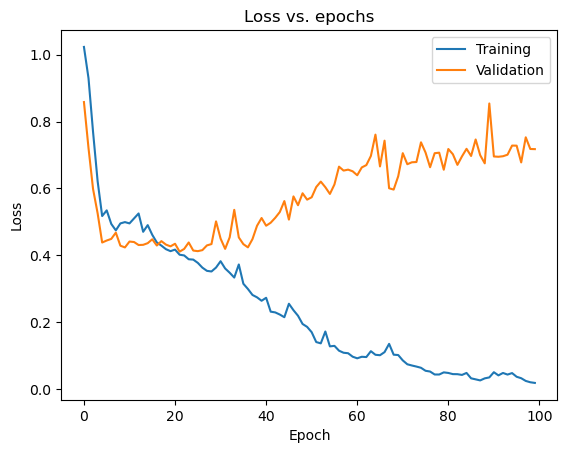

In [15]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [16]:
from tensorflow.keras.layers import Dropout as drop
from tensorflow.keras import regularizers as reg

In [17]:
def get_regularised_model(wd, rate):
    model = seq([
        den(128, activation="relu", kernel_regularizer=reg.l2(wd), input_shape=(train_data.shape[1],)),
        drop(rate),
        den(128, kernel_regularizer=reg.l2(wd), activation="relu"),
        drop(rate),
        den(128, kernel_regularizer=reg.l2(wd), activation="relu"),
        drop(rate),
        den(128, kernel_regularizer=reg.l2(wd), activation="relu"),
        drop(rate),
        den(128, kernel_regularizer=reg.l2(wd), activation="relu"),
        drop(rate),
        den(128, kernel_regularizer=reg.l2(wd), activation="relu"),
        drop(rate),
        den(1)
    ])
    return model

In [18]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, 0.3)

In [19]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [20]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_target, epochs=100, validation_split=0.15, batch_size=64,verbose=False)

In [21]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.5424 - mae: 0.5394 - 26ms/epoch - 13ms/step


[0.5424423813819885, 0.5394349694252014]

#### Plot the learning curves

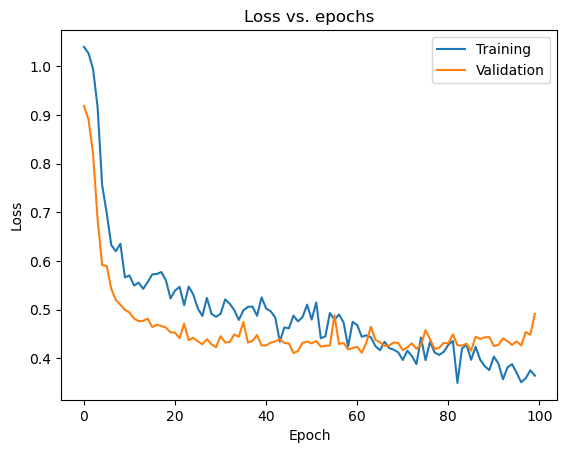

In [22]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [23]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback as cb

class my_callback(cb):

    def on_train_begin(self, logs=None):
        print("Starting training....")
    
    def on_epoch_begin(self, epoch, logs=None):
        print(f'Starting epoch (epoch)')
    
    def on_train_batch_begin(self, batch, logs=None):
        print(f'Training: Starting batch (batch)')
    def on_train_batch_end(self, batch, logs=None):
        print(f'Training: Finished batch (batch)' )
    def on_epoch_end(self, epoch, logs=None):
        print(f'Training: Finishing epoch (epoch)')
    def on_train_end(self, logs=None):
        print("Finished Training")

In [24]:
# Re-build the model
model = get_regularised_model(1e-5, 0.3)


In [25]:
# Compile the model

model.compile(optimizer='adam', loss='mse')

#### Train the model with the callback

In [26]:
# Train the model, with some of the data reserved for validation

from gc import callbacks


model.fit(train_data,train_target, epochs=3, batch_size=64, verbose=False, callbacks=[my_callback()])

Starting training....
Starting epoch (epoch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Finishing epoch (epoch)
Starting epoch (epoch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Trainin

In [27]:
# Evaluate the model

model.evaluate(test_data, test_targets)

2/2 [==============================] - 0s 0s/step - loss: 0.6454


0.6453595757484436

In [28]:
# Make predictions with the model
class my_callback_predict(cb):

    def on_predict_begin(self, logs=None):
        print("Starting training....")
        
    def on_predict_batch_begin(self, batch, logs=None):
        print(f'Training: Starting batch (batch)')
    def on_predict_batch_end(self, batch, logs=None):
        print(f'Training: Finished batch (batch)' )

    def on_predict_end(self, logs=None):
        print("Finished Training")

model.predict(test_data, verbose=False, callbacks=[my_callback_predict()])

Starting training....
Training: Starting batch (batch)
Training: Finished batch (batch)
Training: Starting batch (batch)
Training: Finished batch (batch)
Finished Training


array([[ 0.23681553],
       [-0.11370535],
       [ 0.4599626 ],
       [ 0.39722848],
       [-0.17797871],
       [-0.16707383],
       [ 0.15573445],
       [-0.11892422],
       [-0.15237507],
       [ 0.23470609],
       [-0.13381672],
       [ 0.23138045],
       [-0.05263314],
       [ 0.43195164],
       [-0.14291114],
       [ 0.03035198],
       [-0.04937341],
       [ 0.08274064],
       [-0.11058743],
       [ 0.38439658],
       [ 0.40713596],
       [-0.13554491],
       [ 0.11326163],
       [-0.07107286],
       [ 0.2641474 ],
       [-0.16189098],
       [-0.15742703],
       [ 0.25216523],
       [ 0.30269626],
       [-0.14236839],
       [ 0.19517861],
       [ 0.32063603],
       [ 0.07472717],
       [-0.05787326],
       [ 0.04874732],
       [ 0.24307974],
       [-0.17238022],
       [ 0.21679313],
       [ 0.07173193],
       [ 0.3539095 ],
       [ 0.06521749],
       [-0.14041132],
       [-0.09100393],
       [ 0.33841664],
       [ 0.05697821]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [29]:
# Re-train the unregularised model

unregularised_model = get_model()
unregularised_model.compile(optimizer='adam', loss='mse')
unreg_history = unregularised_model.fit(train_data, train_target,  epochs=100, validation_split=0.15, batch_size=64, verbose=False,
                                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)] )

In [30]:
# Evaluate the model on the test set

unregularised_model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.3449 - 21ms/epoch - 10ms/step


0.34494078159332275

In [31]:
# Re-train the regularised model
regularized_model = get_regularised_model(1e-8,0.2)
regularized_model.compile(optimizer='adam', loss='mse')
reg_history = regularized_model.fit(train_data,train_target, epochs=100, validation_split=0.15, batch_size=64, verbose=False, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [32]:
# Evaluate the model on the test set

regularized_model.evaluate(test_data,test_targets)

2/2 [==============================] - 0s 2ms/step - loss: 0.4337


0.4336715340614319

#### Plot the learning curves

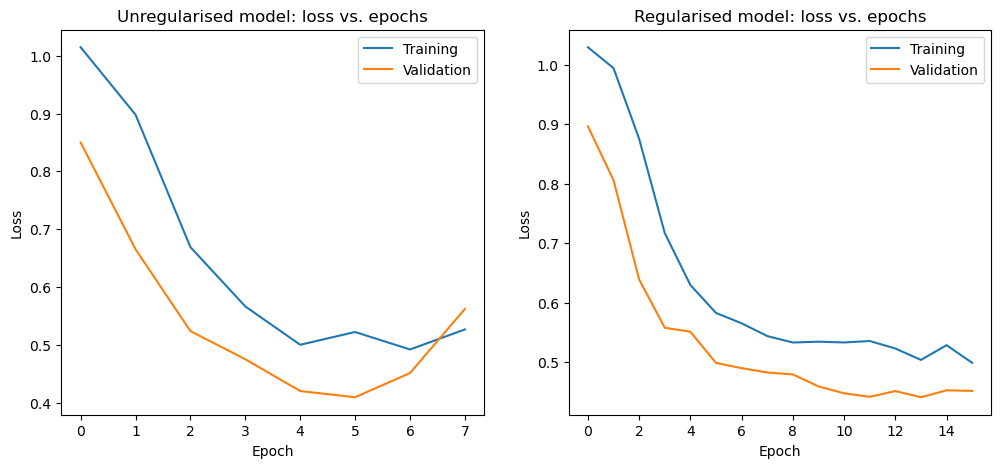

In [33]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()